# MillenniumAI performance comparison

### Set executable paths

In [2]:
# Path to MillenniumDB/MillenniumAI executables
SERVER_PYMDB_PATH = "/home/zeus/MDB/MillenniumDB-Dev/build/Release/bin/server_pymdb"
CREATE_DB_PATH = "/home/zeus/MDB/MillenniumDB-Dev/build/Release/bin/create_db"

# Port to run MillenniumDB server on
SERVER_PORT = 8080

In [18]:
import sys
import networkx as nx
import matplotlib.pyplot as plt
import os
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
from torch_geometric.loader import NeighborLoader
import torch
import subprocess
from typing import Tuple, List, Dict
import socket
import time

# Necessary to import from sibling directory
sys.path.append("..")


from pymdb import (
    MDBClient,
    TrainGraphLoader,
    EvalGraphLoader,
    SamplingGraphLoader,
    Sampler,
)


### Define performance test function

In [53]:
# Generate graphs in NetworkX and MillenniumDB format. Returns the in-memory graph and the path to the on-disk graph.
def generate_graph(
    num_nodes: int,
    num_edges: int,
    num_node_feat: int,
) -> Tuple[Data, str]:
    # In-memory graph
    graph = from_networkx(
        nx.gnm_random_graph(num_nodes, num_edges, seed=2023, directed=True)
    )
    graph.node_feat = torch.rand(num_nodes, num_node_feat, dtype=torch.float32)
    graph.node_label = torch.randint(0, 2, (num_nodes,), dtype=torch.uint8)

    # On-disk MillenniumDB graph
    dump_path = f"N{num_nodes}_E{num_edges}_F{num_node_feat}.milldb"
    with open(dump_path, "w") as f:
        for idx in range(graph.num_nodes):
            f.write(
                f"N{idx} :L{graph.node_label[idx]} feat:{graph.node_feat[idx].tolist()}\n"
            )
        for edge in graph.edge_index.T:
            f.write(f"N{edge[0]}->N{edge[1]} :T\n")
    return graph, dump_path


# Create a MillenniumDB database from a file in the current directory and return its path
def create_db(dump_path: str) -> str:
    dest_path = os.path.basename(dump_path).replace(".milldb", "")

    if os.path.isdir(dest_path):
        subprocess.run(["rm", "-rf", dest_path])

    result = subprocess.run(
        [CREATE_DB_PATH, dump_path, dest_path],
        stdout=subprocess.DEVNULL,
        stderr=subprocess.PIPE,
    )
    if result.returncode != 0:
        raise RuntimeError(f"create_db: {result.stderr.decode('utf-8')}")
    return dest_path


# Start a MillenniumDB server for a given database directory
def start_server(db_path: str):
    process = subprocess.Popen(
        [SERVER_PYMDB_PATH, db_path, "-p", str(SERVER_PORT)],
        stdout=subprocess.DEVNULL,
        stderr=subprocess.PIPE,
    )

    # Wait for server to listen to port
    while socket.socket().connect_ex(("localhost", SERVER_PORT)) != 0:
        time.sleep(0.5)

    return process


# Kill a MillenniumDB server process and return its exit code
def kill_server(process) -> int:
    process.kill()
    return process.wait()


# Define a function to compute the size of a graph (in MB)
def instance_size(instance: Dict) -> int:
    return (
        instance["num_nodes"] * 8
        + instance["num_node_feat"] * instance["num_nodes"] *4
        + instance["num_edges"] * 8 * 2
    ) / 1e6


# Run performance tests for a list of instances and a list of batch sizes
def run_performance_tests(instances: List[Dict], batch_sizes: List[int]):
    plot_data = dict()
    for batch_size in batch_sizes:
        plot_data[batch_size] = dict()
        times_mem = list()
        times_mdb = list()

        print(f"Running for batch size: {batch_size}...")

        for instance in instances:
            # Generate graphs and create database
            graph, dump_path = generate_graph(**instance)
            db_path = create_db(dump_path)

            print(f"  Running for instance: {instance}...")

            # 1. In-memory graph
            print("    In-memory graph...")
            t0_mem = time.perf_counter_ns()
            for batch in NeighborLoader(
                graph, num_neighbors=[5], batch_size=batch_size
            ):
                # Here the batch would be passed to a model
                pass
            times_mem.append((time.perf_counter_ns() - t0_mem) / 1e9)

            # 2. MillenniumDB graph
            print("    MillenniumDB graph...")
            # Start MillenniumDB server
            server_process = start_server(db_path)
            # Connect to server
            with MDBClient("localhost", SERVER_PORT) as client:
                t0_mdb = time.perf_counter_ns()
                for batch in EvalGraphLoader(
                    client, num_neighbors=[5], batch_size=batch_size
                ):
                    # Here the batch would be passed to a model
                    pass
                times_mdb.append((time.perf_counter_ns() - t0_mdb) / 1e9)

            # Clean up
            kill_server(server_process)
            subprocess.run(["rm", "-rf", db_path])
            subprocess.run(["rm", dump_path])

        plot_data[batch_size]["mem"] = times_mem
        plot_data[batch_size]["mdb"] = times_mdb
        plot_data[batch_size]["size"] = [
            instance_size(instance) for instance in instances
        ]

    return plot_data


### Run performance tests for instances

In [58]:
instances = [
    {"num_nodes": 100, "num_edges": 1_000, "num_node_feat": 10},
    {"num_nodes": 1_000, "num_edges": 10_000, "num_node_feat": 100},
    {"num_nodes": 10_000, "num_edges": 20_000, "num_node_feat": 1000},
]

args = {"instances": instances, "batch_sizes": [10, 50, 100, 500, 750, 1000]}

plot_data = run_performance_tests(**args)


Running for batch size: 10...
  Running for instance: {'num_nodes': 100, 'num_edges': 1000, 'num_node_feat': 10}...
    In-memory graph...
    MillenniumDB graph...
  Running for instance: {'num_nodes': 1000, 'num_edges': 10000, 'num_node_feat': 100}...
    In-memory graph...
    MillenniumDB graph...
  Running for instance: {'num_nodes': 10000, 'num_edges': 20000, 'num_node_feat': 1000}...
    In-memory graph...
    MillenniumDB graph...
Running for batch size: 50...
  Running for instance: {'num_nodes': 100, 'num_edges': 1000, 'num_node_feat': 10}...
    In-memory graph...
    MillenniumDB graph...
  Running for instance: {'num_nodes': 1000, 'num_edges': 10000, 'num_node_feat': 100}...
    In-memory graph...
    MillenniumDB graph...
  Running for instance: {'num_nodes': 10000, 'num_edges': 20000, 'num_node_feat': 1000}...
    In-memory graph...
    MillenniumDB graph...
Running for batch size: 100...
  Running for instance: {'num_nodes': 100, 'num_edges': 1000, 'num_node_feat': 10}.

In [59]:
def plot_comparison(x: List, y1: List, y2: List, x_label: str, y_label: str, title: str):
    plt.plot(x, y1, label="In-memory")
    plt.plot(x, y2, label="MillenniumDB")
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.show()

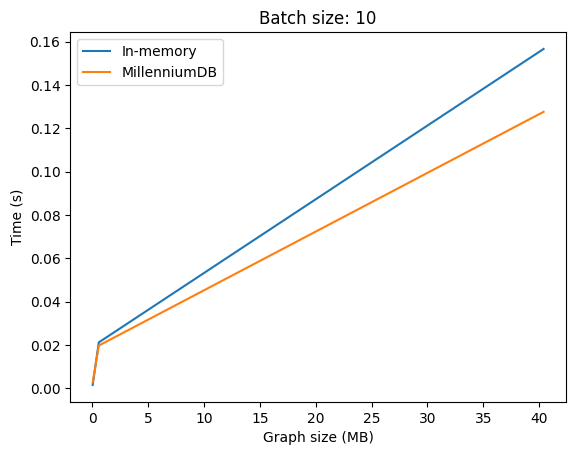

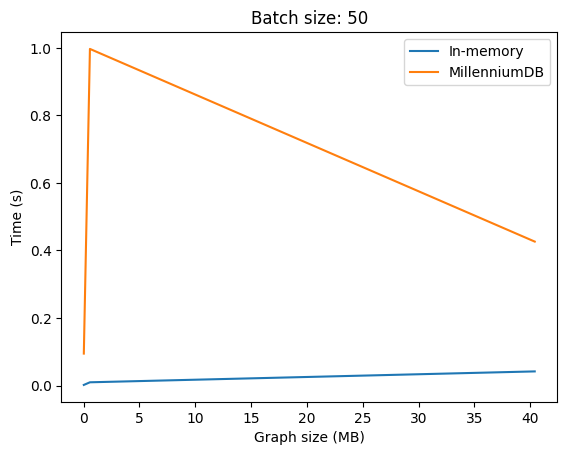

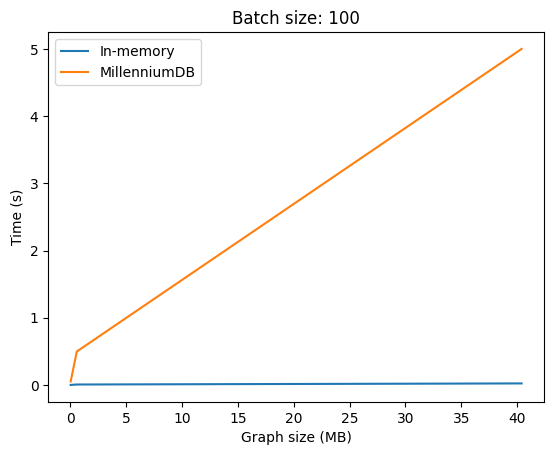

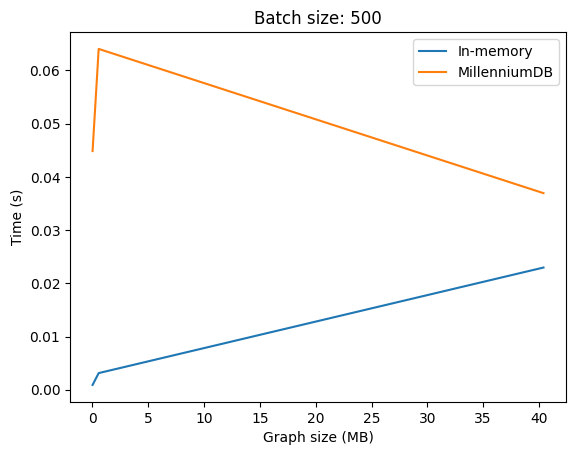

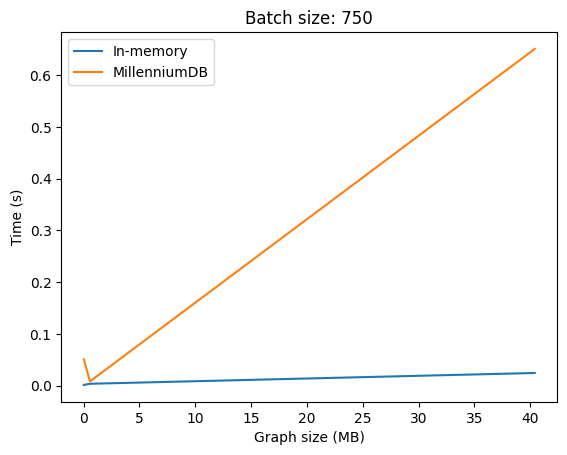

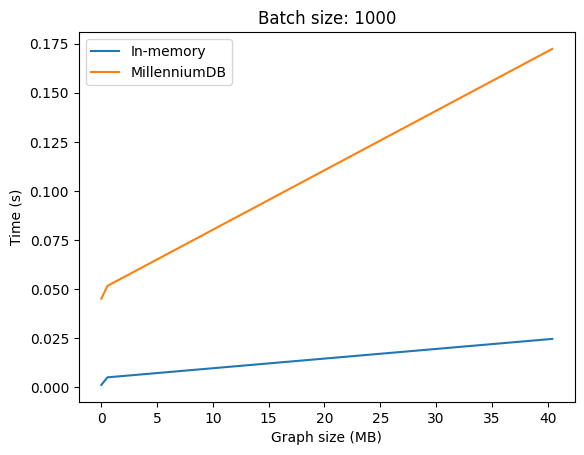

In [60]:
# Compare time over graph size
for batch_size, data in plot_data.items():
    plot_comparison(
        data["size"],
        data["mem"],
        data["mdb"],
        "Graph size (MB)",
        "Time (s)",
        f"Batch size: {batch_size}",
    )